# Time series forcasting using ARIMA

In [9]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.arima.model as sm
import matplotlib.pyplot as plt

In [10]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})

In [11]:
# Import data (usage of website)
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

In [12]:
df.head()

,value
0,88
1,84
2,85
3,85
4,84


## Find d (Order of differencing)

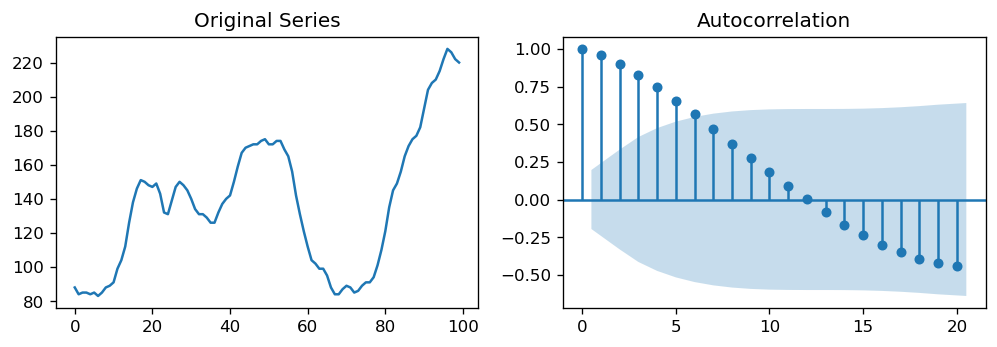

In [13]:
# Original Series
fig, axes = plt.subplots(1, 2)
axes[0].plot(df["value"])
axes[0].set_title('Original Series')
plot_acf(df["value"], ax=axes[1])
plt.show()

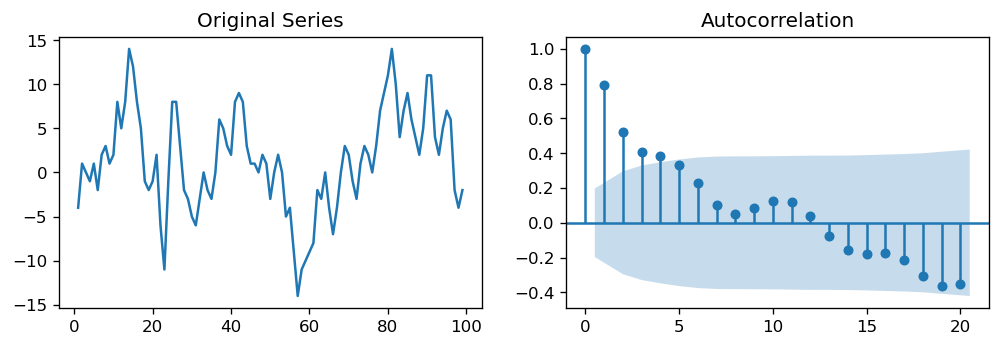

In [14]:
# 1st Differencing
fig, axes = plt.subplots(1, 2)
axes[0].plot(df["value"].diff())
axes[0].set_title('Original Series')
plot_acf(df["value"].diff().dropna(), ax=axes[1])
plt.show()

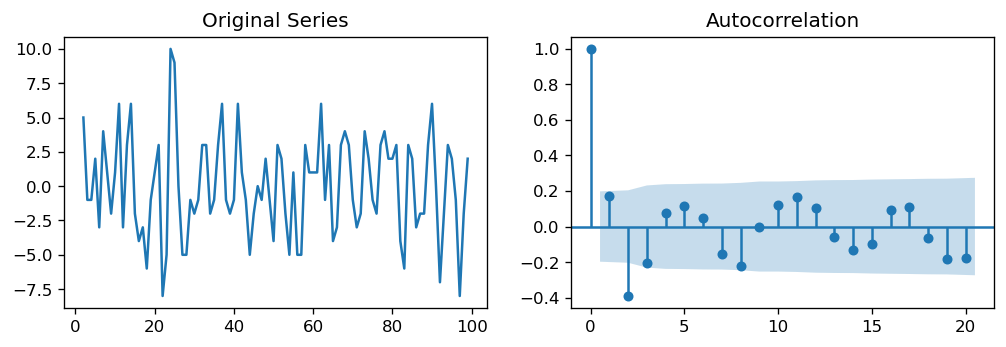

In [15]:
# 2nd Differencing
fig, axes = plt.subplots(1, 2)
axes[0].plot(df["value"].diff().diff())
axes[0].set_title('Original Series')
plot_acf(df["value"].diff().diff().dropna(), ax=axes[1])
plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced. So, I am going to tentatively fix the order of differencing as 1 even though the series is not perfectly stationary (weak stationarity).

## Find p (order in AR terms)

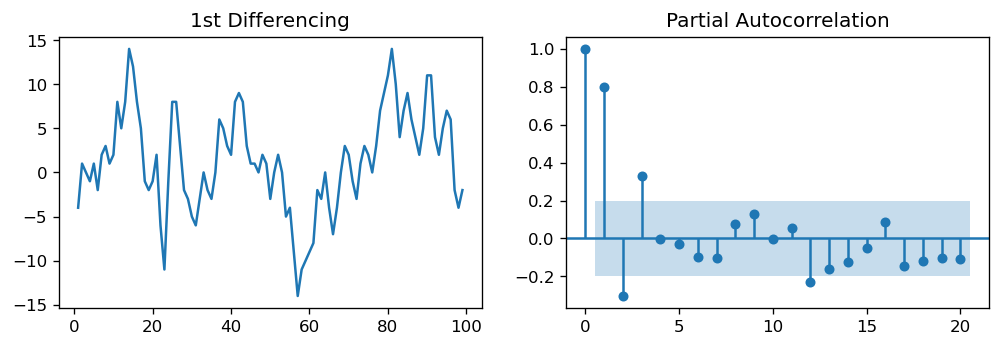

In [16]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(df["value"].diff())
axes[0].set_title('1st Differencing')
plot_pacf(df["value"].diff().dropna(), ax=axes[1])
plt.show()

You can observe that the PACF lag 1 is quite significant since is well above the significance line. Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region). But I am going to be conservative and tentatively fix the p as 1.

## Find q (order of MA)

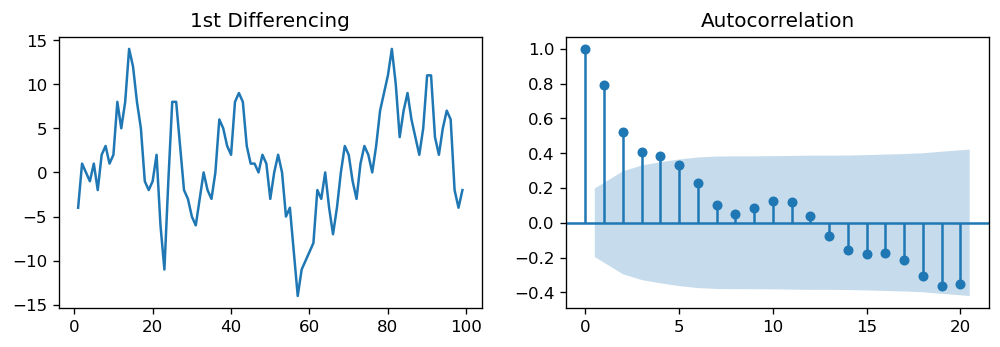

In [17]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(df["value"].diff())
axes[0].set_title('1st Differencing')
plot_acf(df["value"].diff().dropna(), ax=axes[1])
plt.show()

Couple of lags are well above the significance line. So, let’s tentatively fix q as 2. When in doubt, go with the simpler model that sufficiently explains the Y.

## 1,1,2 ARIMA Model
- p = 1 (AR order)
- d = 1 (Difference)
- q = 2 (MA order) 

In [18]:
model = sm.ARIMA(df["value"], order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -254.126
Date:                Wed, 17 Mar 2021   AIC                            516.253
Time:                        10:37:28   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.6

The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms. 

The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model into a single statistic. When comparing two models, the one with the lower AIC is generally “better”.


Notice here the coefficient of the MA2 term is close to zero and the P-Value in ‘P>|z|’ column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant. So, let’s rebuild the model without the MA2 term.

## 1,1,1 ARIMA Model
- p = 1 (AR order)
- d = 1 (Difference)
- q = 1 (MA order) 


In [19]:
# 1,1,1 ARIMA Model
model = sm.ARIMA(df.value, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -254.150
Date:                Wed, 17 Mar 2021   AIC                            514.300
Time:                        10:37:29   BIC                            522.086
Sample:                             0   HQIC                           517.450
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6504      0.090      7.258      0.000       0.475       0.826
ma.L1          0.5256      0.088      5.994      0.000       0.354       0.697
sigma2         9.7934      1.405      6.970      0.0

The model AIC has reduced, which is good. The P Values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).

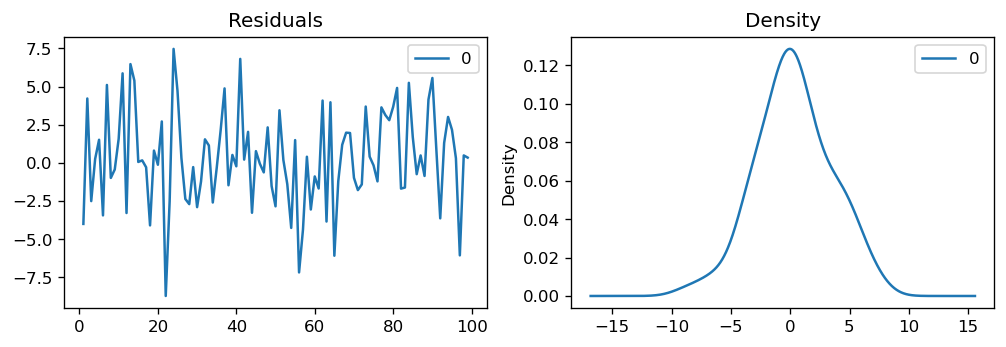

In [20]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid[1:])
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance.

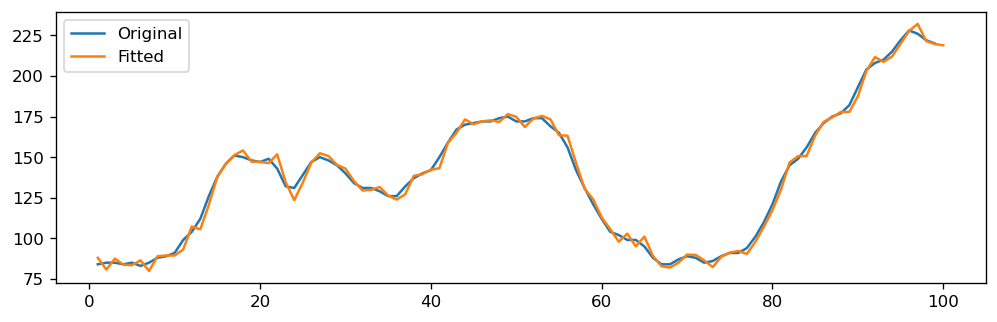

In [21]:
fig, ax = plt.subplots(1,1)
ax.plot(df[1:],label="Original")
ax.plot(model_fit.predict(1,len(df)),label="Fitted")
ax.legend()

In [22]:
# Prediction
model_fit.predict(0,101)

0        0.000000
1       88.002357
2       80.779179
3       87.506935
4       83.739184
          ...    
97     232.064658
98     221.511709
99     219.655162
100    218.880504
101    218.152418
Name: predicted_mean, Length: 102, dtype: float64

### Forecasting

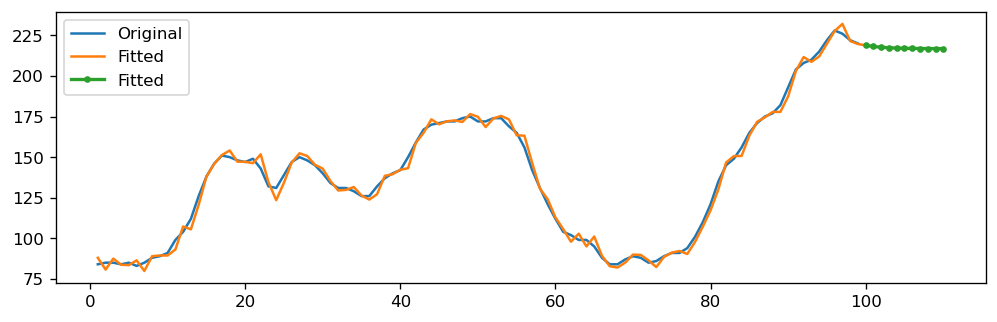

In [23]:
#Forecast
num_forecast = 10
#Y forecast
num_forecast_array = model_fit.predict(len(df),len(df)+num_forecast)
#X forecast
x_forecast = np.arange(len(df),len(df)+num_forecast+1)

fig, ax = plt.subplots(1,1)
ax.plot(df[1:],label="Original")
ax.plot(model_fit.predict(1,len(df)),label="Fitted")
ax.plot(np.arange(len(df),len(df)+num_forecast+1), num_forecast_array,label="Fitted",marker='o', linewidth=2, markersize=3)
ax.legend()

## Auto ARIMA

In [24]:
import pmdarima as pm

In [25]:
model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=525.587, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=533.474, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=532.437, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=525.893, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=531.477, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=515.248, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=513.459, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=515.284, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=511.465, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=530.444, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=513.291, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=513.256, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=523.592, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time

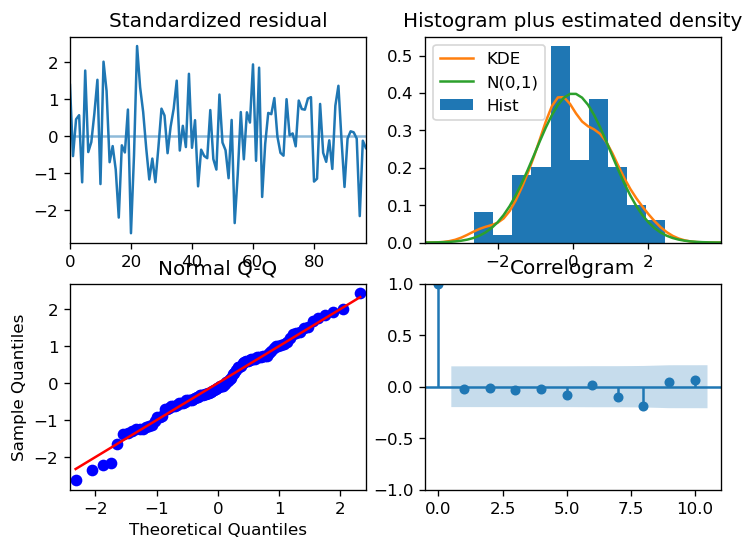

In [26]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

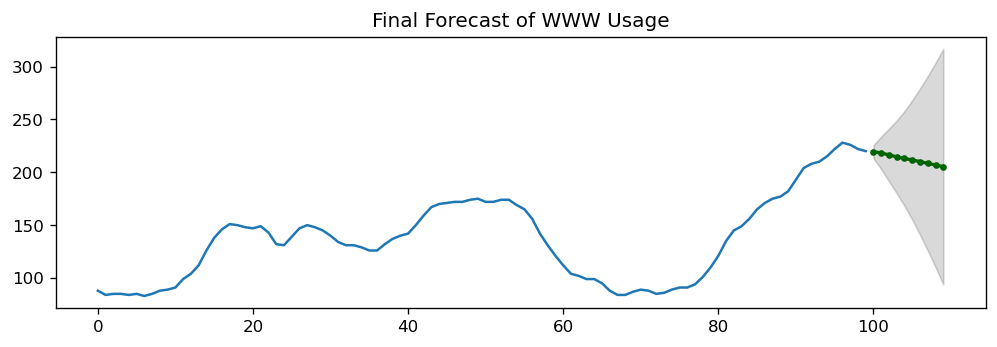

In [27]:
n_periods = 10
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen',marker='o', linewidth=2, markersize=3)
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()